Imports and Bandit Definition

In [2]:

import numpy as np
import matplotlib.pyplot as plt


class MultiArmedBandit:
    """A simple multi-armed bandit environment."""
    def __init__(self, k=10):
        self.k = k
        # True means are drawn from a standard normal distribution
        self.true_means = np.random.normal(0, 1, k)
        self.best_arm = np.argmax(self.true_means)

    def pull(self, arm):
        """Pulls an arm and returns a reward from a normal distribution
        with the arm's true mean and variance 1."""
        return np.random.normal(self.true_means[arm], 1)

Agent Implementation


In [3]:

class EpsilonGreedyAgent:
    """An agent that follows the epsilon-greedy strategy."""
    def __init__(self, k, epsilon=0.1):
        self.k = k
        self.epsilon = epsilon
        self.counts = np.zeros(k, dtype=int)  # Number of times each arm was pulled
        self.values = np.zeros(k, dtype=float) # Estimated value of each arm

    def select_action(self):
        """Selects an arm using the epsilon-greedy strategy."""
        # : With probability self.epsilon, select a random arm (explore).
        # Otherwise, select the arm with the current highest estimated value (exploit).
        if np.random.rand() < self.epsilon:
            # Explore: select a random arm
            return np.random.randint(self.k)
        else:
            # Exploit: select the arm with the highest estimated value
            return np.argmax(self.values)

    def update(self, arm, reward):
        """Updates the estimated value of the pulled arm."""
        self.counts[arm] += 1
        n = self.counts[arm]
        # : Update self.values[arm] using the incremental sample-average formula:
        # NewEstimate = OldEstimate + (1/n) * (Reward - OldEstimate)
        self.values[arm] += (1 / n) * (reward - self.values[arm])

class EpsilonGreedyDecayAgent(EpsilonGreedyAgent):
    """An agent that uses a decaying epsilon."""
    def __init__(self, k):
        super().__init__(k)
        self.t = 0 # Timestep counter

    def select_action(self):
        """Selects an action with an epsilon that decays over time."""
        self.t += 1
        # : Calculate the decaying epsilon for the current timestep t.
        epsilon = 1.0 / self.t

        # Then, use the same exploration/exploitation logic as the parent class.
        if np.random.rand() < epsilon:
            return np.random.randint(self.k)
        else:
            return np.argmax(self.values)

class UCB1Agent:
    """An agent that follows the Upper Confidence Bound (UCB1) strategy."""
    def __init__(self, k, c=2.0):
        self.k = k
        self.c = c
        self.counts = np.zeros(k, dtype=int)
        self.values = np.zeros(k, dtype=float)
        self.t = 0 # Timestep counter

    def select_action(self):
        """Selects an arm using the UCB1 formula."""
        self.t += 1

        # : First, ensure each arm is played at least once.
        # Check if any arm has a count of 0. If so, return that arm.
        for arm in range(self.k):
            if self.counts[arm] == 0:
                return arm

        # : If all arms have been played once, calculate the UCB1 value for each arm.
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)

        # : Return the arm with the highest UCB value.
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        """Updates the estimated value of the pulled arm."""
        self.counts[arm] += 1
        n = self.counts[arm]
        # : Update self.values[arm] using the incremental sample-average formula.
        # (This is the same as in the EpsilonGreedyAgent)
        self.values[arm] += (1 / n) * (reward - self.values[arm])



Experiment Runner and Plotting

In [4]:
def run_experiment(agent_class, k=10, runs=2000, steps=1000, **agent_kwargs):
    """Runs the bandit experiment for a given agent class."""
    all_rewards = np.zeros((runs, steps))
    for run in range(runs):
        if (run + 1) % 200 == 0:
            print(f"Running {agent_class.__name__}: Run {run+1}/{runs}")
        bandit = MultiArmedBandit(k=k)
        agent = agent_class(k=k, **agent_kwargs)
        for t in range(steps):
            arm = agent.select_action()
            reward = bandit.pull(arm)
            agent.update(arm, reward)
            all_rewards[run, t] = reward
    return all_rewards.mean(axis=0)




Run and plot

Running UCB1Agent: Run 200/2000
Running UCB1Agent: Run 400/2000
Running UCB1Agent: Run 600/2000
Running UCB1Agent: Run 800/2000
Running UCB1Agent: Run 1000/2000
Running UCB1Agent: Run 1200/2000
Running UCB1Agent: Run 1400/2000
Running UCB1Agent: Run 1600/2000
Running UCB1Agent: Run 1800/2000
Running UCB1Agent: Run 2000/2000
Running EpsilonGreedyAgent: Run 200/2000
Running EpsilonGreedyAgent: Run 400/2000
Running EpsilonGreedyAgent: Run 600/2000
Running EpsilonGreedyAgent: Run 800/2000
Running EpsilonGreedyAgent: Run 1000/2000
Running EpsilonGreedyAgent: Run 1200/2000
Running EpsilonGreedyAgent: Run 1400/2000
Running EpsilonGreedyAgent: Run 1600/2000
Running EpsilonGreedyAgent: Run 1800/2000
Running EpsilonGreedyAgent: Run 2000/2000
Running EpsilonGreedyDecayAgent: Run 200/2000
Running EpsilonGreedyDecayAgent: Run 400/2000
Running EpsilonGreedyDecayAgent: Run 600/2000
Running EpsilonGreedyDecayAgent: Run 800/2000
Running EpsilonGreedyDecayAgent: Run 1000/2000
Running EpsilonGreedyDecayA

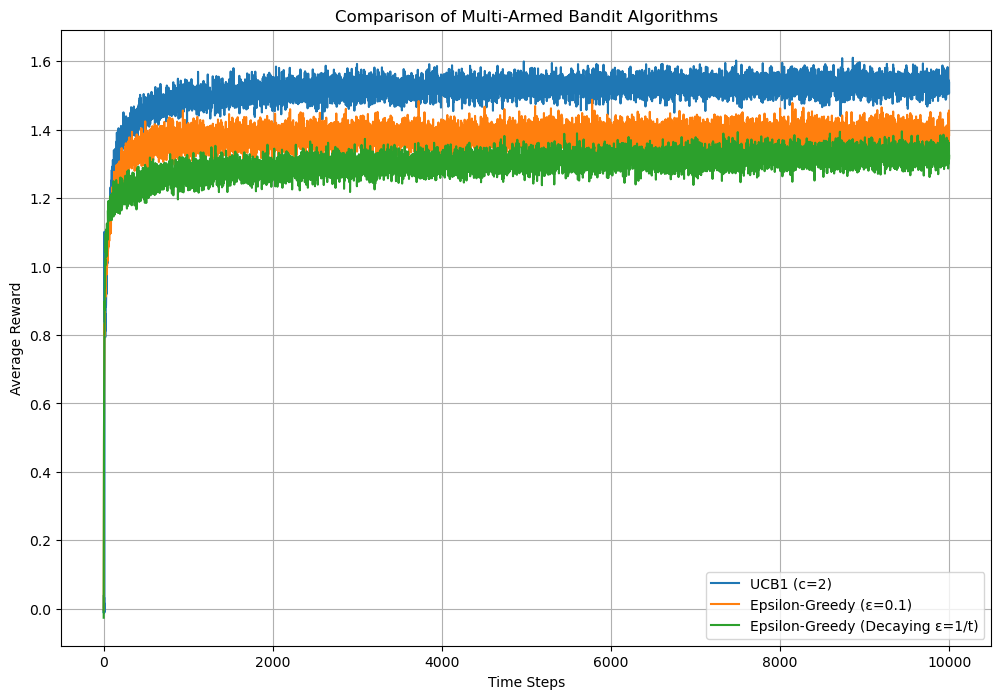

In [5]:
# Run experiments for all agents
r_ucb = run_experiment(UCB1Agent, c=2.0, steps=10000)
r_fixed = run_experiment(EpsilonGreedyAgent, epsilon=0.1, steps=10000)
r_decay = run_experiment(EpsilonGreedyDecayAgent, steps=10000)

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(r_ucb, label='UCB1 (c=2)')
plt.plot(r_fixed, label='Epsilon-Greedy (ε=0.1)')
plt.plot(r_decay, label='Epsilon-Greedy (Decaying ε=1/t)')
plt.xlabel('Time Steps')
plt.ylabel('Average Reward')
plt.title('Comparison of Multi-Armed Bandit Algorithms')
plt.legend()
plt.grid(True)
plt.show()